In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 235 (delta 106), reused 210 (delta 89), pack-reused 0
Receiving objects: 100% (235/235), 30.54 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (106/106), done.
--2021-12-02 15:42:40--  https://docs.google.com/uc?export=download&confirm=9fTq&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 173.194.192.100, 173.194.192.138, 173.194.192.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.192.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-b4-docs.googleusercontent.com/docs/securesc/hduqkjo0ecqbges05kqandmgbdp4qguq/nv4finof3iddj8h0h6qia5b2aogj2tqq/1638459750000/06419056966375271799/11884025400924978205Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-12-02 15:42:40--  https://doc-10-b4-doc

In [ ]:
from dul_2021.utils.hw5_utils import *


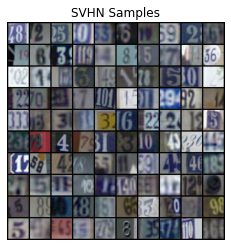

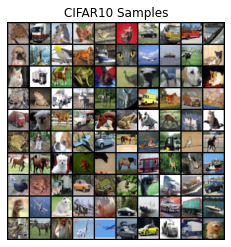

In [ ]:
visualize_svhn()
visualize_cifar10()

In [ ]:
import itertools

import torch
import numpy as np
import torch.optim as opt
import torch.nn.functional as F

from torch import nn
from torch.distributions import Normal, MultivariateNormal
from torch.utils.data import DataLoader
from tqdm import tqdm, trange


class Trainer:
    def __init__(self, n_epochs, lr, grad_clip=None, device="cpu"):
        self.n_epochs = n_epochs
        self.device = device
        self.lr = lr
        self.grad_clip = grad_clip

    def fit(self, model, train_loader, val_loader):
        train_metrics = []
        test_metrics = []

        optimizer = opt.Adam(model.parameters(), lr=self.lr)

        model.to(self.device)
        test_metrics.append(self.evaluate(model, val_loader))
        for epoch in range(self.n_epochs):
            model.train()
            tqdm_steps = tqdm(train_loader, desc=f"Training")
            for batch in tqdm_steps:
                res = self._step(model, batch)
                loss = res["loss"]

                optimizer.zero_grad()
                loss.backward()
                if self.grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.grad_clip)
                optimizer.step()

                train_metrics.append({k: v.item() for k, v in res.items()})
                tqdm_steps.set_postfix(train_loss=loss.item())

            test_metrics.append(self.evaluate(model, val_loader))

        return train_metrics, test_metrics

    def _step(self, model, batch, return_rec=False):
        x = batch.to(self.device, dtype=torch.float32)
        res = model(x)
        if not return_rec:
            del res["x_rec"]
        return res

    @torch.no_grad()
    def evaluate(self, model, val_loader):
        model_out = []
        model.eval()
        for batch in val_loader:
            res = self._step(model, batch)
            model_out.append(res)

        res = {
            "loss": np.mean([el["loss"].cpu().numpy() for el in model_out]),
            "rec_loss": np.mean([el["rec_loss"].cpu().numpy() for el in model_out]),
            "kl_loss": np.mean([el["kl_loss"].cpu().numpy() for el in model_out]),
        }

        return res


class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            *[
                nn.Conv2d(3, 32, 3, 1, 1),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, 2, 1), # 16
                nn.ReLU(),
                nn.Conv2d(64, 128, 3, 2, 1), # 8
                nn.ReLU(),
                nn.Conv2d(128, 256, 3, 2, 1), # 4
                nn.ReLU(),
                nn.Conv2d(256, 512, 3, 2, 1), # 2
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(2 * 2 * 512, 2 * latent_dim),
            ]
        )

        self.decoder = nn.Sequential(
            *[
                nn.ConvTranspose2d(256, 128, 4, 2, 1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 4, 2, 1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, 4, 2, 1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 3, 4, 2, 1),
            ]
        )

        self.decoder_linear = nn.Linear(latent_dim, 2 * 2 * 256)

        self.register_buffer("c", self.latent_dim * torch.tensor(2 * np.pi).log())

        print(sum([p.numel() for p in self.parameters()]))

    @property
    def device(self):
        return next(iter(self.parameters())).device

    @property
    def p_z(self):
        return MultivariateNormal(
            torch.zeros(self.latent_dim, device=self.device), torch.eye(self.latent_dim, device=self.device)
        )

    def encode(self, x):
        # encoding
        x_enc = self.encoder(x)

        mu, log_sigma = x_enc.chunk(2, dim=-1)
        sigma = log_sigma.exp()

        z = mu + torch.randn_like(mu) * sigma

        return z, mu, sigma

    def decode(self, z):
        bs = z.shape[0]
        mu_z = self.decoder_linear(z).reshape(bs, 256, 2, 2)
        mu_z = self.decoder(mu_z)

        return mu_z

    def forward(self, x):
        bs = x.shape[0]

        z, mu, sigma = self.encode(x)

        kl_loss = 1 / 2 * (sigma.sum(-1) + (mu * mu).sum(-1) - 1 - (sigma + 1e-8).log().sum(-1))
        kl_loss = kl_loss.mean()

        mu_z = self.decode(z)

        reconstruction_loss = 0.5 * (x - mu_z) ** 2
        reconstruction_loss = reconstruction_loss.reshape(bs, -1).sum(1).mean()

        loss = reconstruction_loss + kl_loss

        return {"loss": loss, "rec_loss": reconstruction_loss, "kl_loss": kl_loss, "x_rec": mu_z}

    @torch.inference_mode()
    def sample(self, n=100):
        z = self.p_z.sample((n,))
        mu_z = self.decoder_linear(z).reshape(n, 256, 2, 2)
        mu_z = self.decoder(mu_z)

        return mu_z

    @torch.inference_mode()
    def reconstruct(self, x):
        res = self(x)
        return res["x_rec"]

    @torch.inference_mode()
    def interpolate(self, x):
        # encoding
        z, *_ = self.encode(x)

        z1s, z2s = z.chunk(2, dim=0)

        res = []

        for z1, z2 in zip(z1s, z2s):
            inter = [self.decode((alpha * z1 + (1 - alpha) * z2).unsqueeze(0)) for alpha in np.linspace(0.0, 1.0, 10)]
            res.extend(inter)

        return torch.vstack(res).cpu().numpy()


def transform(x):
    return 2 * (np.transpose(x, (0, 3, 1, 2)) / 255.0).astype('float32') - 1


def transform_inverse(x):
    return (np.transpose(np.clip(x, -1, 1), (0, 2, 3, 1)) * 0.5 + 0.5).astype('float32') * 255


def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    batch_size = 128
    n_epochs = 50
    lr = 1e-3
    latent_dim = 32

    device = torch.device("cuda")
    grad_clip = 1

    train_data = transform(train_data)
    test_data = transform(test_data)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=batch_size)

    model = VAE(latent_dim=latent_dim)

    trainer = Trainer(n_epochs=n_epochs, lr=lr, grad_clip=grad_clip, device=device)

    train_metrics, test_metrics = trainer.fit(model, train_loader, val_loader)
    train_metrics = np.vstack([list(el.values()) for el in train_metrics])
    test_metrics = np.vstack([list(el.values()) for el in test_metrics])

    samples = model.sample().cpu().numpy()
    test_samples = next(iter(val_loader))[:50].to(device, dtype=torch.float32)
    test_samples_rec = model.reconstruct(test_samples)

    rec = torch.vstack([test_samples, test_samples_rec]).cpu().numpy()
    inter = model.interpolate(next(iter(val_loader))[:20].to(device, dtype=torch.float32))

    return (
        train_metrics,
        test_metrics,
        transform_inverse(samples),
        transform_inverse(rec),
        transform_inverse(inter),
    )


2423395


Training: 100%|██████████| 79/79 [00:06<00:00, 12.73it/s, train_loss=47.7]


Final -ELBO: 64.2781, Recon Loss: 33.6229, KL Loss: 30.6552


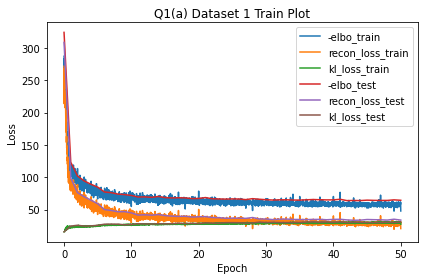

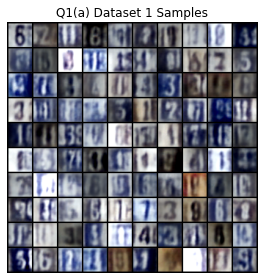

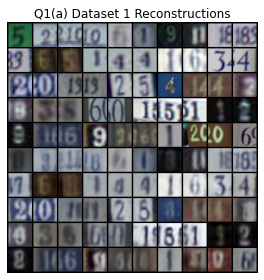

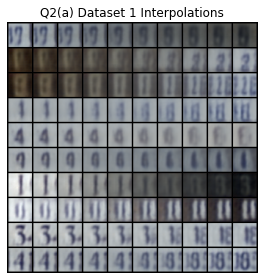

In [ ]:
q1_save_results('a', 1, q1_a)